# 四. Logit regression

## 1. 模型 

考虑一个二分类任务，其生产标记$y\in \{0,1\}$，而线性回归模型产生的预测值$z=\mathbf{\omega^Tx+b}$是实数，于是需将$z$转换为0/1值。直观地，可以考虑"单位阶跃函数"
$$
\begin{equation}
y=\begin{cases}
0,z<0;\\
0.5,z=0;\\
1,z>0.
\end{cases}
\end{equation}
$$
即若预测值$z$大于0则判为正例。显然，单位阶越函数是不连续函数，因此退而使用有更好性质的对数几率函数（logistic function）:
$$
y=\frac{1}{1+e^{-z}}.
$$
显然对数几率函数可以将z值转换为一个接近0或1的值，且在$z=0$附近变化很陡。

将$z=\mathbf{\omega^Tx+b}$代入对数几率函数，可得
$$
y=\frac{1}{1+e^{-\mathbf{\omega^Tx+b}}}.
$$
进而转换为
$$
\mathrm{ln}\frac{y}{1-y}=\mathbf{\omega^Tx+b}.
$$
若将$y$视为样本$\mathbf{x}$作为正例的可能性，则$1-y$是其反例可能性，两者比值为
$$
\frac{y}{1-y}
$$
称为几率（odd），反映了x作为正例的相对可能性。对几率取自然对数则可得对数几率（log odds, 也称为logit）
$$
\mathrm{ln}\frac{y}{1-y}
$$
通过“极大似然法”来估计$\omega$和$b$，给定数据集$\{(x_i,y_i)\}^m_{i=1}$，最大化对数似然率
$$
\text{max  } \mathbf{l(w,b)}=\sum_{i=1}^m \mathrm{ln}p(y_i|\mathbf{x_i;w,b})
$$
即令每个样本属于其真实标记的概率越大越好。上式又等价于最小化负对数似然率
$$
(\omega, b)^* = \text{argmin  } \mathbf{l(w,b)}=\sum_{i=1}^m\left(-y_i(\omega^Tx_i+b)+\mathbf{ln}(1+e^{\omega^Tx_i+b})\right)
$$

令$\beta = (\omega, b), \hat{x}_i = (x_i, 1)$，则有
$$
\beta^* = \text{argmin  } \mathbf{l(\beta)}=\sum_{i=1}^m\left(-y_i \hat{x}_i \beta^T+\mathbf{ln}(1+e^{\beta^T \hat{x}_i})\right)
$$

对$\beta$求梯度可得
$$
\mathbf{\frac{\partial l}{\partial \beta}}=\sum_{i=1}^m(-y_i+\frac{1}{1+e^{-\beta^T\hat{x}_i}})\hat{x}_i
$$
令$\hat{y}_i=\frac{1}{1+e^{-\beta^T\hat{x}_i}}$，则有
$$
\begin{aligned}
\mathbf{\frac{\partial l}{\partial \beta}}&=\sum_{i=1}^m(\hat{y}_i-y_i)\hat{x}_i \\
&=(\hat{y}-y)^T \hat{X} 
\end{aligned}
$$

In [1]:
%matplotlib inline
from IPython import display
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
def f(z):
    if z < 0:
        return 0
    elif z == 0:
        return 0.5
    else:
        return 1

def g(z):
    return 1/(1+np.exp(-z))

函数的向量化

In [11]:
v_f = np.vectorize(f)
v_g = np.vectorize(g)

In [12]:
z = np.linspace(-5, 5, num=200)
y1 = v_f(z)
y2 = v_g(z)

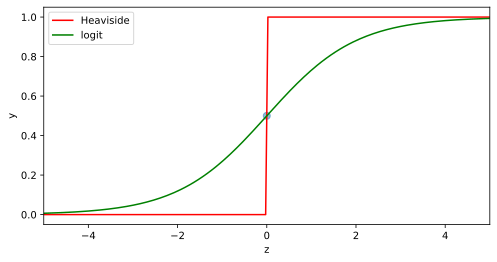

In [13]:
display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z, y1, 'r-', label='Heaviside')
ax.plot(z, y2, 'g-', label='logit')
ax.scatter([0], [0.5], s=50, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.legend()

## 2. 基于`torch`实现Logit回归

In [15]:
# sigmod函数
def sigmoid(X, beta):
    '''
    X: m * d m个样本，每个样本d维特征
    beta: d+1 维, d维特征权重+1维截距
    '''
    hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)
    return torch.sigmoid(hat_X@beta)  # 1 / (1 + torch.exp(-hat_X@beta))

示例数据

In [16]:
true_beta = torch.FloatTensor([4, -2, 1]).reshape(-1, 1)
x = torch.randn(size=(1000, 2)).float()

# 生成数据集
z = sigmoid(x, true_beta)  # 为正例的概率
y = z >= 0.5  # 生成True或False
y = y.float()  # 注意要转换为浮点数，否则后面迭代时报错

x_train = x[:int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]

y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

- 梯度下降

In [17]:
# 负对数似然函数
def neglikelihood(X, y, beta):
    '''
    X: m * d m个样本，每个样本d维特征
    y: m * 1 m个标签
    beta: d+1 维, d维特征权重+1维截距
    '''
    hat_y = sigmoid(X, beta)
    llike = -y.reshape(1, -1)@hat_y + torch.ones_like(hat_y).reshape(1, -1)@torch.log(1 + torch.exp(hat_y))
    return llike

In [18]:
def precision(beta, feature, true_label):
    z = sigmoid(feature, beta)
    y = (z >= 0.5).float()
    return torch.sum(y == true_label).numpy() / len(y)

In [33]:
def sgd_logit(X, y, lr=0.05):
    hat_X = torch.cat([X, torch.ones(X.shape[0], 1)], axis=1)
    beta = torch.randn(X.shape[1] + 1, 1)  # 增广权重
    loss = neglikelihood(X, y, beta)
    trace_loss = loss.numpy()
    while True:
        err = sigmoid(X, beta) - y
        beta = beta - lr * hat_X.t() @ err
        loss = neglikelihood(X, y, beta)
        loss = loss.numpy()
        trace_loss = np.concatenate([trace_loss, loss])
        if np.abs((trace_loss[-1] - trace_loss[-2]) / trace_loss[-1]) < 1e-5:
            break
            
    return beta.squeeze(), trace_loss

In [34]:
est_beta, _ = sgd_logit(x_train, y_train, lr=0.1)
est_beta

tensor([ 33.4040, -17.0180,   8.6806])

In [29]:
train_precision = precision(est_beta.reshape(-1, 1), x_train, y_train)
train_precision

0.99875

In [30]:
test_precision = precision(est_beta.reshape(-1, 1), x_test, y_test)
test_precision

1.0

- 利用`torch`自动求导机制实现小批量随机梯度下降

In [39]:
def mini_batch_sgd(X, y, loss_func, num_epoch=50, batch_size=20, lr=0.05):
    dataset = TensorDataset(X, y)
    data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    beta = torch.randn(x_train.shape[1] + 1, 1)
    beta.requires_grad_()

    for epoch in range(num_epochs):
        for t_x, t_y in data_iter:
            l = loss_func(t_x, t_y, beta)        
            l.backward()  # 计算损失函数在 [w,b] 上的梯度
            beta.data.sub_(lr*beta.grad/batch_size)
            beta.grad.data.zero_()
            
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():  # 不计算梯度，加速损失函数的运算
                train_l = loss_func(t_x, t_y, beta)  # 最近一次的负对数似然率
                est_beta = [u[0] for u in beta.detach().numpy()]  # detach得到一个有着和原tensor相同数据的tensor
                train_accu_ratio = precision(beta, X, y)
                print(f'epoch {epoch + 1}, loss: {train_l.numpy()[0][0]:.4f}')
                print(f'    train accuracy: {train_accu_ratio}')
            
    return est_beta, train_l.numpy()

In [40]:
mini_batch_sgd(x_train, y_train, neglikelihood)

epoch 10, loss: 11.8473
    train accuracy: 0.70625
epoch 20, loss: 12.7585
    train accuracy: 0.79375
epoch 30, loss: 11.3368
    train accuracy: 0.84125
epoch 40, loss: 11.2414
    train accuracy: 0.8825
epoch 50, loss: 9.3056
    train accuracy: 0.90875


([3.116284, -1.9249322, 0.0043869996], array([[9.305604]], dtype=float32))

## 参考资料
1. 李航. 统计学习方法. 2017.
2. 邱锡鹏. 神经网络与机器学习. 2020.
3. 周志华. 机器学习. 2019.
4. Christopher M. Bishop. Pattern recognition and machine learning. 2006.